# Ephemeris object cube imaging (mosaic)

## Comet Giacobini-Zinner  - TRACKFIELD

For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. The following demo is one of the stadard procudures for processing of such data.

In [46]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')
#!pip install ipympl

In [47]:
from casatasks import getephemtable, tclean, exportfits, listobs, imstat, imhead
from casatools import measures, quanta, table, image
import os
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pylab as pl
import numpy as np
import aplpy
me = measures()
qa = quanta()
tb = table()
ia = image()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In [48]:
def delete_tcleanimages(imagename):
    ''' clean up images from a previous run '''
    imtypes = ['residual', 'image', 'psf', 'pb', 'model', 'sumwt']
    for type in imtypes:
        if os.path.exists(f'{imagename}.{type}'):
            os.system(f'rm -rf {imagename}.{type}')

In [49]:
def get_attachedEphemtablepath(msfile, fieldname):
    ''' returns full path of attached eph table for a specified field ID'''
    from casatools import table, msmetadata
    import glob
    _tb = table()
    _msmd = msmetadata()
    _msmd.open(msfile)
    fieldid = _msmd.fieldsforname(fieldname)[0]
    _msmd.close()
    _tb.open(msfile+'/FIELD')
    ephemid = _tb.getcell('EPHEMERIS_ID',fieldid)
    _tb.close()
    tabname = glob.glob(f'{msfile}/FIELD/EPHEM{ephemid}*/')
    return tabname[0]
    

In [50]:
def ephem_dir(ephemtab, refep, observatory):
    from casatools import measures
    _me = measures()
    _me.framecomet(ephemtab)
    _me.doframe(_me.observatory(observatory))
    _me.doframe(_me.epoch('utc',refep))
    return _me.measure(_me.measure(_me.direction('COMET'), 'AZELGEO'),'ICRS')

## Imaging with epehemeris data attached to the MS

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available.


In [51]:
datapath='/home/casa/data/casatestdata-large/stakeholder/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/stakeholder/alma/'

In [52]:
msfile=[datapath+'2017.1.00750.T_tclean_exe1.ms',datapath+'2017.1.00750.T_tclean_exe2.ms']

In [53]:
imgname='tst-cubesrc-trackfield'

In [54]:
delete_tcleanimages(imgname)

In [55]:
#os.system(f'cp -r {datapath}{msfile} {msfile}')

In [56]:
ret=tclean(vis=msfile, field='21PGiacobini-Zinner', spw=['0', '0'], \
            antenna=['0,1,2,3,4,5,6,7,8,9,10,11', '0,1,2,3,4,5,6,7,8,9'], \
            scan=['7,11,15,19,23', '8,12,16,20,24'], \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=imgname, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter='TRACKFIELD', stokes='I', specmode='cubesource', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, \
            gridder='mosaic', mosweight=False, \
            usepointing=True, pblimit=0.2, deconvolver='hogbom', \
            restoration=True, restoringbeam='common', pbcor=True, \
            #weighting='briggsbwtaper', robust=0.5, npixels=0, niter=30000, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.274Jy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0, fastnoise=False, restart=True, \
            calcres=True, calcpsf=True, savemodel='none', \
            parallel=False, verbose=True)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


363

Convert a CASA image to FITS image for displaying the image via aplpy

In [57]:
# SPECSYS=SOURCE is not yet supported in astropy?
def displayImage(imgname, markers={}, title=''):
    ''' convert casa image to fits and display the fits image'''
    # export to a FITS image (overwrite if the output exists)
    fitsimagename = imgname+'fits'
    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
    fits.setval(fitsimagename, 'TIMESYS', value='utc')
    # REST (SOURCE) is not yet supported in astropy ?
    # for time being set to LSRK so the image can be displayed
    fits.setval(fitsimagename, 'SPECSYS', value='LSRK')
    fig = pl.figure(figsize=(15,15))
    #fig = pl.figure()
    #fig.add_subplot(121)
    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.4,0.5])
    img.show_colorscale()
    if markers!={}:
       img.show_markers(markers['ra'], markers['dec'], edgecolor='red', marker='o',s=10, alpha=0.5)
    pl.title(title)
    #fig.canvas.draw()
    print(printImageCenter(imgname))
    ax2 = pl.add_axes([0.6,0.1,0.8,0.5])
    ia.open(imgname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    ploc = np.where( pix == pix.max() )
    pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
    pl.title('Spectrum at source peak')
    pl.xlabel('Channel')

In [58]:
def printImageCenter(imgname):
    ia.open(imgname)
    shape = ia.shape()
    csys = ia.coordsys()
    center = csys.toworld([shape[0]/2.,shape[1]/2.])
    ia.done()
    return qa.time(qa.quantity(center['numeric'][0], 'rad'),prec=9)[0], qa.angle(qa.quantity(center['numeric'][1],'rad'),prec=9)[0]


In [59]:
# another way to display image (from CASADocs simulation example )
def dispAstropy(imname='sim_onepoint_true.im', chanslice=0):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
       # print(hdu.header)
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,chanslice,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')


def dispImage(imname='sim_onepoint_true.im', chanslice=0, useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(20,10))
    pl.clf()
    #if shp[3]>1:   
    if useAstropy==False:
        pl.subplot(121)
        pl.imshow(pix[chanslice,0,:,:])
        pl.title(f'Image from channel {chanslice}')
    else:
        dispAstropy(imname,chanslice)
        #displayImage(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')

def casadatetoastropydate(casadatestring):
    datelist = casadatestring.split('/')
    retstr=''
    if len(datelist)==4:
        retstr=datelist[0]+'-'+datelist[1]+'-'+datelist[2]+'T'+datelist[3]
    return retstr    

In [60]:
imstatres = imstat(imgname+'.image')
maxchan = imstatres['maxpos'][3]
print(maxchan)

488


In [61]:
# extract the channel image
from casatasks import imsubimage
os.system(f'rm -rf {imgname}ch{maxchan}.image')
imsubimage(imagename=imgname+'.image', outfile=f'{imgname}ch{maxchan}.image', chans=f'{maxchan}')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Figure size 2000x1000 with 0 Axes>

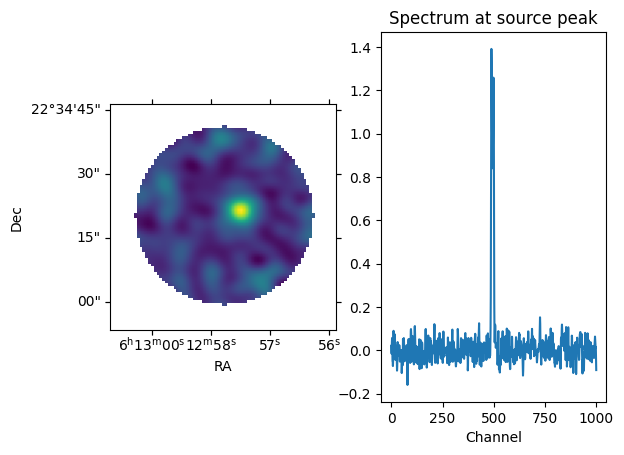

In [62]:
dispImage(f'{imgname}.image',chanslice=maxchan, useAstropy=True)

In [63]:
obsdate = imhead('tst-cubesrc-trackfield.image', mode='list')['date-obs']
print(obsdate)

2018/09/16/10:15:58.895999


In [64]:
ephemtab = get_attachedEphemtablepath(msfile[0],'21PGiacobini-Zinner')
ineph_dir = ephem_dir(ephemtab, obsdate,'ALMA')

In [65]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9)[0],qa.angle(ineph_dir['m1'],prec=9)[0])
print('image center:',printImageCenter(imgname+'.image'))

internal ephem dir =  06:12:57.770 +022.34.20.236
image center: ('06:12:57.770', '+022.34.20.236')


Determine image channel frequency at the peak 

In [66]:
ia.open('tst-cubesrc-trackfield.image')
csys = ia.coordsys()
csysrec = csys.torecord()
ia.done()
restfreq = csysrec['spectral2']['restfreq']
print('restfreq:',restfreq)

restfreq: 354505473000.0


In [67]:
# find image frequency at the peak
specaxis=csys.findcoordinate('spectral')['pixel'][0]
pixel=csys.referencepixel()

In [68]:
pixel['numeric'][specaxis] = 488
print(pixel)
f_peak = csys.toworld(pixel)['numeric'][specaxis]
# this is different from what I read from the Viewer
print(f_peak,'Hz')

{'ar_type': 'absolute', 'numeric': array([ 40.,  40.,   0., 488.]), 'pw_type': 'pixel'}
354504857166.2119 Hz


The spectrum is centered around the rest freqeuncy. This is roughly indicate the 'SOURCE' 
frame trasformation is done correctly.

In [69]:
#print(casadatetoastropydate(obsdate))

In [70]:
from casatools import measures
ephemtab = get_attachedEphemtablepath(msfile[0], '21PGiacobini-Zinner')
me.framecomet(ephemtab)
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch('utc',obsdate))
cometpos = me.measure(me.direction('COMET'),'ICRS')
print(cometpos)

{'m0': {'unit': 'rad', 'value': 1.6273353091131537}, 'm1': {'unit': 'rad', 'value': 0.39388505484928327}, 'refer': 'ICRS', 'type': 'direction'}


In [71]:
# reference time 
mjd0=qa.quantity(obsdate,'d')['value']
print(mjd0)

58377.427764999986


In [72]:
# from the epehemeris table get radial velociity at the ref time (first timestamp)
tb.open(ephemtab)
mjdcol = tb.getcol('MJD')
#indx = np.abs(mjdcol - mjd0).argmin()
#radvel = tb.getcell('RadVel',indx)
radc = tb.getcol('RA')
decdc = tb.getcol('DEC')
rhoc = tb.getcol('Rho')
radvel=tb.getcol('RadVel')
tb.done()

True

In [73]:
radv = np.interp(mjd0,mjdcol,radvel)
qradv = qa.convert(qa.quantity(radv,'AU/d'),'km/s')
raval = np.interp(mjd0,mjdcol,radc)
decval= np.interp(mjd0,mjdcol,decdc)
rhoval = np.interp(mjd0,mjdcol,rhoc)
print(qradv)
print(raval,decval)

{'unit': 'km/s', 'value': 3.35206559623668}
93.24003966532386 22.57365939602003


In [74]:
# following frequencies are measured on the viewer 
# imaging with TOPO
ftopo = 354.50107*10**9
# imaging with LSRK
flsrk = 354.48068*10**9
vrad = qradv['value']
me.doframe(me.observatory('ALMA'))
me.doframe(me.epoch(str(mjd0)+'d'))
v = me.radialvelocity('GEO',str(-1*vrad)+'km/s')
dop=me.todoppler('radio',v)
print(f'vel={v}')
print(f'dop={dop}')
#mfrq = me.frequency('LSRK', qa.quantity(flsrk,'Hz'))
mfrq = me.frequency('TOPO', qa.quantity(ftopo,'Hz'))
print(mfrq)
print('expected frequecy at the peak in rest(source) frame:',me.tofrequency('rest', dop, mfrq))
print(f'compared to freq_peak from the image = {f_peak} Hz')

vel={'m0': {'unit': 'm/s', 'value': -3352.06559623668}, 'refer': 'GEO', 'type': 'radialvelocity'}
dop={'m0': {'unit': 'm/s', 'value': -3352.084336653307}, 'refer': 'RADIO', 'type': 'doppler'}
{'m0': {'unit': 'Hz', 'value': 354501070000.0}, 'refer': 'TOPO', 'type': 'frequency'}
expected frequecy at the peak in rest(source) frame: {'m0': {'unit': 'Hz', 'value': 354505033800.4638}, 'refer': 'REST', 'type': 'frequency'}
compared to freq_peak from the image = 354504857166.2119 Hz


In [75]:
print('diff = ',354505033800.4638-354504979266.61194)
print('chan width : ',0.1221004*10**6)

diff =  54533.85186767578
chan width :  122100.4


### Attempt to do the check with astropy....

In [76]:
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord
from astropy.time import Time

In [77]:
almaloc = EarthLocation.of_site('ALMA')
alma = almaloc.get_itrs(obstime=Time(casadatetoastropydate(obsdate)))
print(alma)

<ITRS Coordinate (obstime=2018-09-16T10:15:58.896, location=(0., 0., 0.) km): (x, y, z) in m
    (2225015.30883296, -5440016.41799762, -2481631.27428014)>


In [78]:
comet = SkyCoord(ra=raval * u.deg, dec=decval * u.deg, frame='gcrs', radial_velocity=qradv['value'] * u.km/  u.s, distance = rhoval * u.AU)
print(comet)

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (93.24003967, 22.5736594, 0.39746107)
 (radial_velocity) in km / s
    (3.3520656,)>


In [79]:
freqs_topo =np.array([354.500098,354.5011])
print(freqs_topo)

[354.500098 354.5011  ]


In [80]:
sc_comet=SpectralCoord(freqs_topo * u.GHz, observer = alma, target = comet)
sc_comet

<SpectralCoord 
   (observer: <ITRS Coordinate (obstime=2018-09-16T10:15:58.896, location=(0., 0., 0.) km): (x, y, z) in m
                  (2225015.30883296, -5440016.41799762, -2481631.27428014)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <GCRS Coordinate (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
                (93.24003967, 22.5736594, 0.39746107)
             (radial_velocity) in km / s
                (3.3520656,)>
    observer to target (computed from above):
      radial_velocity=-3.936246432419361 km / s
      redshift=-1.3129818600909893e-05)
  [354.500098, 354.5011  ] GHz>

In [81]:
sc_comet.with_observer_stationary_relative_to('gcrs')

<SpectralCoord 
   (observer: <GCRS Coordinate (obstime=2018-09-16T10:15:58.896, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (x, y, z) in m
                  (882677.99324444, 5810188.03280754, -2483054.59405962)
               (v_x, v_y, v_z) in km / s
                  (-1.23066362e-07, 3.12672928e-08, 4.5443885e-09)>
    target: <GCRS Coordinate (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
                (93.24003967, 22.5736594, 0.39746107)
             (radial_velocity) in km / s
                (3.3520656,)>
    observer to target (computed from above):
      radial_velocity=-3.6218222884181834 km / s
      redshift=-1.2081025770438458e-05)
  [354.4997262, 354.5007282] GHz>

In [82]:
sc_comet.with_observer_stationary_relative_to('icrs')

<SpectralCoord 
   (observer: <ICRS Coordinate: (x, y, z) in m
                  (1.49373631e+11, -1.52176398e+10, -6.61552286e+09)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <GCRS Coordinate (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
                (93.24003967, 22.5736594, 0.39746107)
             (radial_velocity) in km / s
                (3.3520656,)>
    observer to target (computed from above):
      radial_velocity=17.30843785637034 km / s
      redshift=5.773640087447518e-05)
  [354.47497737, 354.4759793 ] GHz>

In [83]:
sc_comet.with_observer_stationary_relative_to('lsrk')

<SpectralCoord 
   (observer: <LSRK Coordinate: (x, y, z) in m
                  (1.49373631e+11, -1.52176398e+10, -6.61552286e+09)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <GCRS Coordinate (obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
                (93.24003967, 22.5736594, 0.39746107)
             (radial_velocity) in km / s
                (3.3520656,)>
    observer to target (computed from above):
      radial_velocity=7.857684588050327 km / s
      redshift=2.6210758001576906e-05)
  [354.48615213, 354.48715409] GHz>

In [84]:
sc_comet.with_observer_stationary_relative_to('sc_comet.target')

TypeError: 'NoneType' object is not callable

# astropy example

In [85]:
location = EarthLocation.of_site('ALMA')  
alma = location.get_itrs(obstime=Time('2019-04-24T02:32:10'))

In [86]:
ttau = SkyCoord('04h21m59.43s +19d32m06.4', frame='icrs',
                radial_velocity=23.9 * u.km / u.s, distance=144.321 * u.pc)
            #radial_velocity=23.9 * u.km / u.s)
ttau

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (65.497625, 19.53511111, 144.321)
 (radial_velocity) in km / s
    (23.9,)>

In [87]:
sc_ttau = SpectralCoord(np.linspace(200, 300, 11) * u.GHz,
                        observer=alma, target=ttau)  
sc_ttau

<SpectralCoord 
   (observer: <ITRS Coordinate (obstime=2019-04-24T02:32:10.000, location=(0., 0., 0.) km): (x, y, z) in m
                  (2225015.30883296, -5440016.41799762, -2481631.27428014)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <ICRS Coordinate: (ra, dec, distance) in (deg, deg, pc)
                (65.497625, 19.53511111, 144.321)
             (radial_velocity) in km / s
                (23.9,)>
    observer to target (computed from above):
      radial_velocity=41.03594953774002 km / s
      redshift=0.00013689056329480032)
  [200., 210., 220., 230., 240., 250., 260., 270., 280., 290., 300.] GHz>